In [1]:
# mtcnn installation
!pip install /kaggle/input/mtcnn1/mtcnn-0.1.0-py3-none-any.whl -q
!pip install /kaggle/input/facenet/facenet_pytorch-2.2.9-py3-none-any.whl -q
!pip install mtcnn -q

# Hyperparameters Configuration

In [2]:
import os
from enum import Enum

class ModelType(Enum):
    RESNET50 = "resnet50"
    EFFICIENTNET = "efficientnet"
    CUSTOM_CNN = "custom_cnn"

# Dataset config
DATASET_PATH = "/kaggle/input/deepfake-detection-challenge/train_sample_videos"
TRAIN_RATIO = 0.8
FRAME_SAMPLE_RATE = 1

# Face detection config
FACE_DETECTION_SIZE = (224, 224)
MIN_FACE_CONFIDENCE = 0.8

# EVA config
EVA_LEVELS = 4
EVA_AMPLIFICATION_FACTOR = 10
EVA_FREQUENCY_MIN = 0.05
EVA_FREQUENCY_MAX = 0.4

# Training config
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 1e-4
FEATURE_DIM = 512

# Paths
MODEL_SAVE_PATH = "saved_models"
VISUALIZATION_PATH = "visualizations"

# Extract Faces from videos

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from mtcnn import MTCNN # face cropping model
from matplotlib import pyplot as plt

import extract_faces as ef
# dir(ef)

Using TensorFlow backend.


In [4]:
df = ef.create_dataframe('/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json')
for i in range(len(df)):
    df['video_name'][i] = os.path.join(DATASET_PATH, df['video_name'][i])

In [5]:
final_df = df

In [6]:
dataset_dir = "dataset"
real_dir = "real"
fake_dir = "fake"

try:
    os.makedirs(os.path.join(dataset_dir, real_dir))
    os.makedirs(os.path.join(dataset_dir, fake_dir))
except FileExistsError:
    print(f"One or more directory with the given name already exists.")
except Exception as e:
    print(f"An error occured: {e}")

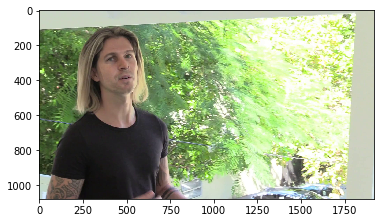

In [7]:
# VideoCapture(var), take path as var to open a video
import cv2
from matplotlib import pyplot as plt

cap = cv2.VideoCapture(df.iloc[0][0])
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.show()
    break
cap.release()


In [8]:
# DataLoader class
class DeepfakeDataLoader:
    def __init__(self):
        self.detector = MTCNN()
        self.real_path = "/kaggle/working/dataset/real"
        self.fake_path = "/kaggle/working/dataset/fake"

    def _detect_face(self, frame):
        """Detect and crop face using MTCNN-tensorflow backend"""
        results = self.detector.detect_faces(frame)
        if not results:
            return None
        # change the logic here for multiple faces
        best_face = max(results, key=lambda x: x['confidence'])
        if best_face['confidence'] < MIN_FACE_CONFIDENCE:
            return None
        # change this to isotropic resizing
        # bounding box
        x, y, w, h = best_face['box']
        x, y = max(0, x), max(0, y)

        # crop and resize
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, FACE_DETECTION_SIZE)
        return face

    def load_video_frames(self, video_path, max_frames=100):
        """Load and preprocess video frames"""
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0

        while cap.isOpened() and frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % FRAME_SAMPLE_RATE == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                face = self._detect_face(frame)
                if face is not None:
                    frames.append(face)

            frame_count += 1
        cap.release()
        return np.array(frames)

    def create_video(self, df, loc_path):
        w, h, _ = df[1][0].shape # first frame

        codec = cv2.VideoWriter_fourcc(*'mp4v')
        vid_writer = cv2.VideoWriter(os.path.join(loc_path, df[0]), codec, 30, (w, h))

        # for frames in df[1]:
        #     for _ in range(20):
        #         vid_writer.write(frames)
        for frames in df[1]:
            frames = cv2.cvtColor(frames, cv2.COLOR_BGR2RGB)
            vid_writer.write(frames)

        vid_writer.release()

    def load_dataset(self, df):
        """Load entire dataset"""
        real_videos = []
        fake_videos = []
        real = df[df['label']=="REAL"].values.tolist()
        fake = df[df['label']=="FAKE"].values.tolist()
        false = "off"
        try:
            print("Loading real videos...")
            for video_file in tqdm(real):
                frames = self.load_video_frames(video_file[0])
                if len(frames) > 0:
                    real_videos.append([video_file[0].split("/")[-1], frames])
            for video_file in real_videos:
                self.create_video(video_file, self.real_path)
                
            # plot some samples
            print(f"Few samples of the Real class.")
            plt.subplot(1, 3, 1)
            plt.imshow(real_videos[0][1][0])
            plt.axis(false)
            plt.subplot(1, 3, 2)
            plt.imshow(real_videos[0][1][1])
            plt.axis(false)
            plt.subplot(1, 3, 3)
            plt.imshow(real_videos[0][1][2])
            plt.axis(false)
            plt.show()
        except Exception as e:
            print(f"Encountered an error : {e}")
            
        try:
            print("Loading fake vidoes...")
            for video_file in tqdm(fake):
                frames = self.load_video_frames(video_file[0])
                if len(frames) > 0:
                    fake_videos.append([video_file[0].split("/")[-1], frames])
            for video_file in fake_videos:
                self.create_video(video_file, self.fake_path)
    
            # plot some samples
            print(f"Few samples of the Fake class.")
            plt.subplot(1, 3, 1)
            plt.imshow(fake_videos[0][1][0])
            plt.axis(false)
            plt.subplot(1, 3, 2)
            plt.imshow(fake_videos[0][1][1])
            plt.axis(false)
            plt.subplot(1, 3, 3)
            plt.imshow(fake_videos[0][1][2])
            plt.axis(false)
            plt.show()
        except Exception as e:
            print(f"Encounterd an error : {e}")
        return real_videos, fake_videos

## <mark>Change it to complete dataset</mark> and move it to last 

  0%|          | 0/1 [00:00<?, ?it/s]

Loading real videos...


100%|██████████| 1/1 [00:30<00:00, 30.67s/it]


Few samples of the Real class.


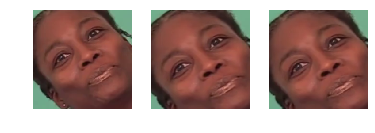

  0%|          | 0/3 [00:00<?, ?it/s]

Loading fake vidoes...


100%|██████████| 3/3 [01:10<00:00, 23.65s/it]


Few samples of the Fake class.


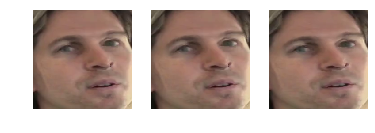

In [9]:
dataloader = DeepfakeDataLoader()
# make it run for all videos
real_videos, fake_videos = dataloader.load_dataset(df.iloc[0:4])

In [10]:
# convert sample videos into gif and present it for demo
gif_dir = "gifs"
real_dir = "real"
fake_dir = "fake"

try:
    os.makedirs(os.path.join(gif_dir, real_dir))
    os.makedirs(os.path.join(gif_dir, fake_dir))
except FileExistsError:
    print(f"One or more directory with the given name already exists.")
except Exception as e:
    print(f"An error occured: {e}")

In [11]:
import cv2
import imageio
import os

def video_to_gif(input_video_path, output_gif_path, fps=10, scale=1.0):
    """Convert videos to gifs"""
    # Read the video using OpenCV
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise ValueError("Could not open the video file")
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * scale)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * scale)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate skip frames to match target FPS
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    skip_frames = max(1, int(video_fps / fps))
    
    print(f"Converting video to GIF: {frame_count} frames, original FPS: {video_fps}, target FPS: {fps}")
    
    frames = []
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Skip frames to match target FPS
        if frame_idx % skip_frames != 0:
            frame_idx += 1
            continue
            
        # Resize if needed
        if scale != 1.0:
            frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
            
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        frame_idx += 1
    
    cap.release()
    
    # Save as GIF using imageio
    imageio.mimsave(output_gif_path, frames, fps=fps, loop=0)
    print(f"GIF saved to {output_gif_path}")

In [12]:
video_to_gif("/kaggle/working/dataset/real/abarnvbtwb.mp4", "/kaggle/working/gifs/real/abarnvbtwb.gif", fps=30)
video_to_gif("/kaggle/working/dataset/fake/aagfhgtpmv.mp4", "/kaggle/working/gifs/fake/aagfhgtpmv.gif", fps=30)

Converting video to GIF: 100 frames, original FPS: 30.0, target FPS: 30
GIF saved to /kaggle/working/gifs/real/abarnvbtwb.gif
Converting video to GIF: 100 frames, original FPS: 30.0, target FPS: 30
GIF saved to /kaggle/working/gifs/fake/aagfhgtpmv.gif


<h3>Sample Videos</h3>
<div style="display:flex;">
    <div>
    <h3>Real Video</h3> 
    <img src="./gifs/real/abarnvbtwb.gif" />
    </div>
    <div>
    <h3>Fake Video</h3> 
    <img src="./gifs/fake/aagfhgtpmv.gif" />
    </div>
</div>

# Applying EVA

In [13]:
import cv2
import numpy as np
from scipy import fftpack

class EulerianVideoAmplification:
    def __init__(self):
        self.levels = EVA_LEVELS
        self.alpha = EVA_AMPLIFICATION_FACTOR
        self.freq_min = EVA_FREQUENCY_MIN
        self.freq_max = EVA_FREQUENCY_MAX

    def _build_gaussian_pyramid(self, frame):
        """Building Gaussian Pyramid for spatial processing"""
        pyramid = [frame]
        for _ in range(self.levels -1 ):
            frame = cv2.pyrDown(frame)
            pyramid.append(frame)
        return pyramid

    def _reconstruct_frame(self, pyramid):
        """Reconstruct frame from Gaussian pyramid"""
        current = pyramid[-1]
        for i in range(len(pyramid)-2, -1, -1):
            current = cv2.pyrUp(current, dstsize=(
                pyramid[i].shape[1], pyramid[i].shape[0]
            ))
            current = cv2.add(current, pyramid[i])
        return current

    def _temporal_bandpass_filter(self, frames):
        """Apply temporal bandpass filter"""
        fft = fftpack.fft(frames, axis=0)
        frequencies = fftpack.fftfreq(len(frames))

        # create bandpass mask
        mask = (np.abs(frequencies) >= self.freq_min) & (np.abs(frequencies) <= self.freq_max)

        # apply mask
        fft[~mask] = 0
        return fftpack.ifft(fft, axis=0).real

    def amplify(self, video_frames):
        """Amplify subtle motion in video"""
        if len(video_frames) < 2:
            return video_frames

        gray_frames = [cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in video_frames]
        gray_frames = np.array(gray_frames)

        # apply temporal bandpass filter
        filtered = self._temporal_bandpass_filter(gray_frames)

        # process each frame
        amplified_frames = []

        for i, frame in enumerate(video_frames):
            # build pyramid for current frame
            pyramid = self._build_gaussian_pyramid(frame)

            # amplify each level
            for level in range(self.levels):
                filtered_level = cv2.pyrDown(filtered[i]) if level > 0 else filtered[i]
                for _ in range(level - 1):
                    filtered_level = cv2.pyrDown(filtered_level)

                # convert grayscale to color
                if len(pyramid[level].shape) == 3:  # If color image
                    filtered_level = cv2.cvtColor(filtered_level.astype(np.uint8), cv2.COLOR_GRAY2RGB)

                pyramid[level] = pyramid[level] + self.alpha * filtered_level

            amplified_frame = self._reconstruct_frame(pyramid)
            amplified_frames.append(amplified_frame)

        return np.array(amplified_frames)

    def process_video(self, video_frames):
        """Process video with EVA and return amplified frames"""
        amplified_frames = self.amplify(video_frames)
        # additional processing - edge detection
        processed_frames = []
        for frame in amplified_frames:
            # converting to LAB color space for edge enhancement
            lab = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)

            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)

            enhanced_lab = cv2.merge((l, a, b))
            enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

            processed_frames.append(enhanced_rgb)
            
        return np.array(processed_frames)

In [14]:
dataset_dir = "processed"
real_dir = "real"
fake_dir = "fake"

try:
    os.makedirs(os.path.join(dataset_dir, real_dir))
    os.makedirs(os.path.join(dataset_dir, fake_dir))
except FileExistsError:
    print(f"One or more directory with the given name already exists.")
except Exception as e:
    print(f"An error occured: {e}")

In [15]:
dataset_dir = "comparision"
real_dir = "real"
fake_dir = "fake"

try:
    os.makedirs(os.path.join(dataset_dir, real_dir))
    os.makedirs(os.path.join(dataset_dir, fake_dir))
except FileExistsError:
    print(f"One or more directory with the given name already exists.")
except Exception as e:
    print(f"An error occured: {e}")

## <mark>Running EVA on processed face video dataset</mark>

In [16]:
# create video of the processed files
def create_video(df, loc_path):
    w, h, _ = df[1][0].shape # first frame

    codec = cv2.VideoWriter_fourcc(*'mp4v')
    vid_writer = cv2.VideoWriter(os.path.join(loc_path, df[0]), codec, 30, (w, h))

    for frames in df[1]:
        # frames = cv2.cvtColor(frames, cv2.COLOR_BGR2RGB)
        vid_writer.write(frames)

    vid_writer.release()

real_path = '/kaggle/working/processed/real'
fake_path = '/kaggle/working/processed/fake'

eva = EulerianVideoAmplification()

try:
    for video in real_videos:
        processed_frames = eva.process_video(video[1])
        create_video([video[0], processed_frames], real_path)
except Exception as e:
    print(f"Encountered an error with real video: {e}")

try:
    for video in fake_videos:
        processed_frames = eva.process_video(video[1])
        create_video([video[0], processed_frames], fake_path)
except Exception as e:
    print(f"Encountered an error with fake video: {e}")

In [17]:
video_to_gif("/kaggle/working/processed/fake/aagfhgtpmv.mp4", "/kaggle/working/gifs/fake/aagfhgtpmv-processed.gif", fps=30)
video_to_gif("/kaggle/working/processed/real/abarnvbtwb.mp4", "/kaggle/working/gifs/real/abarnvbtwb-processed.gif", fps=30)

Converting video to GIF: 100 frames, original FPS: 30.0, target FPS: 30
GIF saved to /kaggle/working/gifs/fake/aagfhgtpmv-processed.gif
Converting video to GIF: 100 frames, original FPS: 30.0, target FPS: 30
GIF saved to /kaggle/working/gifs/real/abarnvbtwb-processed.gif


<h3>Sample Videos</h3>
<div style="display:flex;">
    <div>
    <h3>Real Video</h3> 
    <img src="./gifs/real/abarnvbtwb-processed.gif" />
    </div>
    <div>
    <h3>Fake Video</h3> 
    <img src="./gifs/fake/aagfhgtpmv-processed.gif" />
    </div>
</div>

# Feature Extractor

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

class FeatureExtraction:
    def __init__(self, model_type=ModelType.RESNET50):
        self.model_type = model_type
        self.model = self._build_feature_extractor()

    def _build_feature_extractor(self):
        """Build feature extractor model"""
        input_shape = FACE_DETECTION_SIZE + (3, )
        inputs = Input(shape=input_shape)

        if self.model_type == ModelType.RESNET50:
            base_model = ResNet50(
                weights='imagenet',
                include_top=False,
                input_shape=input_shape
            )
        elif self.model_type == ModelType.EFFICIENTNET:
            base_model = EfficientNetB0(
                weights='imagenet', 
                include_top=False,
                input_shape=input_shape
            )
        else:
            x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
            x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
            x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
            x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
            return Model(inputs=inputs, outputs=x)

        base_model.trainable = False

        x = base_model(inputs)
        x = GlobalAveragePooling2D()(x)
        x = Dense(FEATURE_DIM, activation='relu')(x)

        return Model(inputs=inputs, outputs=x)

    def extract_features(self, frames):
        """Extract features from the video frames"""
        if len(frames.shape) == 3:
            frames = np.expand_dims(frames, axis=0)

        if self.model_type == ModelType.RESNET50:
            processed_frames = tf.keras.applications.resnet50.preprocess_input(frames)
        elif self.model_type == ModelType.EFFICIENTNET:
            processed_frames = tf.keras.applications.efficientnet.preprocess_input(frames)
        else:
            processed_frames = frames / 255.0

        features = self.model.predict(processed_frames)
        return features

    def extract_video_features(self, video_frames):
        """Extract features of all frames in a video"""
        frame_features = []
        for frame in video_frames:
            features = self.extract_features(frame)
            frame_features.append(features)

        video_features = np.mean(frame_features, axis=0)
        return video_features

In [19]:
fe = FeatureExtraction()
features = fe.extract_video_features(fake_videos[0][1])

94773248/94765736 [==============================] - 2s 0us/step


In [20]:
features.shape

(1, 512)

# Vanilla classification model

In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

class DeepfakeClassifier:
    def __init__(self, input_dim=FEATURE_DIM):
        self.model = self._build_classifier(input_dim)

    def _build_classifier(self, input_dim):
        """Build binary classifier model"""
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )

        return model

    def train(self, X_train, y_train, X_val, y_val):
        """Train the classifier"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(
                f"{MODEL_SAVE_PATH}/classifier.h5",
                save_best_only=True,
                monitor='val_accuracy'
            ),
            tf.keras.callbacks.TensorBoard(log_dir='logs')
        ]

        history = self.model.fit(
            X_train, y_train, 
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks
        )

        return history

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        return self.model.evaluate(X_test, y_test)

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)

# Visualizations

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

class DeepfakeVisualizer:
    def __init__(self, feature_extractor, classifier):
        self.feature_extractor = feature_extractor
        self.classifier = classifier

    def plot_training_history(self, history):
        """Plot training and validation metrics"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label="Train Accuracy")
        plt.plot(history.history['val_accuracy'], label="Val Accuracy")
        plt.title("Model Accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label="Train Loss")
        plt.plot(history.history['val_loss'], label="Val Loss")
        plt.title("Model Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{VISUALIZATION_PATH}/training_history.png")
        plt.close()

    # def generate_gradcam(self, frame, layer_name=None):
    #     """Generate Grad-CAM heatmap for a frame"""
    #     if layer_name is None:
    #         if self.feature_extractor.model_type == ModelType.RESNET50:
    #             layer_name = "resnet50"
    #         elif self.feature_extractor.model_type == ModelType.EFFICIENTNET:
    #             layer_name = "top_activation"
    #         else:
    #             layer_name = "conv2d_3"

    #     grad_model = Model(
    #         inputs=[self.feature_extractor.model.inputs],
    #         outputs=[self.feature_extractor.model.get_layer(layer_name).output, self.classifier.model.output]
    #     )

    #     with tf.GradientTape() as tape:
    #         conv_outputs, predictions = grad_model(np.expand_dims(frame, axis=0))
    #         loss = predictions[:, 0]

    #     grads = tape.gradient(loss, conv_outputs)
    #     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #     conv_outputs = conv_outputs[0]
    #     heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    #     heatmap = tf.squeeze(heatmap)

    #     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    #     heatmap = heatmap.numpy()

    #     heatmap = cv2.resize(heatmap, FACE_DETECTION_SIZE)
    #     heatmap = np.uint8(255 * heatmap)

    #     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    #     superimposed_img = cv2.addWeighted(
    #         cv2.cvtColor(frame, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0
    #     )

    #     return superimposed_img

    def visualize_eva_effect(self, original_frames, processed_frames, n_frames=3):
        """Visualize the effect of eva preprocessing"""
        plt.figure(figsize=(15, 5*n_frames))
        
        # Ensure inputs are numpy arrays
        original_frames = np.array(original_frames)
        processed_frames = np.array(processed_frames)
        
        # If single frame provided, convert to list of 1 frame
        if original_frames.ndim == 3:
            original_frames = [original_frames]
            processed_frames = [processed_frames]
        
        for i in range(min(n_frames, len(original_frames))):  # Protect against short arrays
            idx = i * len(original_frames) // n_frames
            
            # Original frame (convert to float [0,1] if needed)
            plt.subplot(n_frames, 2, 2*i+1)
            frame = original_frames[idx]
            if frame.dtype == np.uint8:
                frame = frame.astype(float)/255.0
            plt.imshow(frame)
            plt.title(f"Original Frame {idx}")
            plt.axis("off")
            
            # Processed frame (fixed subplot index)
            plt.subplot(n_frames, 2, 2*i+2)  # Changed to 2*i+2
            frame = processed_frames[idx]
            if frame.dtype == np.uint8:
                frame = frame.astype(float)/255.0
            plt.imshow(frame)
            plt.title(f"Processed Frame {idx}")
            plt.axis("off")
    
        plt.tight_layout()
        plt.savefig(f"{VISUALIZATION_PATH}/eva_effect.png")
        plt.close()

# Train the models

In [23]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

Loading dataset


  0%|          | 0/77 [00:00<?, ?it/s]

Loading real videos...


100%|██████████| 77/77 [34:15<00:00, 26.70s/it]


Few samples of the Real class.


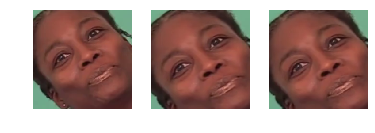

  0%|          | 0/323 [00:00<?, ?it/s]

Loading fake vidoes...


100%|██████████| 323/323 [2:21:07<00:00, 26.21s/it]


Few samples of the Fake class.


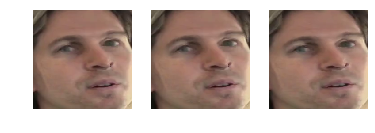

Processing videos with EVA...
Extracting features...
Training classifier...
Train on 252 samples, validate on 64 samples
Epoch 1/200
252/252 [==============================] - 2s 7ms/sample - loss: 6.8699 - accuracy: 0.5595 - auc: 0.5786 - val_loss: 6.6268 - val_accuracy: 0.4688 - val_auc: 0.6290
Epoch 2/200
252/252 [==============================] - 0s 422us/sample - loss: 6.7572 - accuracy: 0.5714 - auc: 0.6222 - val_loss: 6.5487 - val_accuracy: 0.5156 - val_auc: 0.6114
Epoch 3/200
252/252 [==============================] - 0s 430us/sample - loss: 6.7235 - accuracy: 0.5437 - auc: 0.6127 - val_loss: 6.4752 - val_accuracy: 0.6875 - val_auc: 0.5986
Epoch 4/200
252/252 [==============================] - 0s 253us/sample - loss: 6.7136 - accuracy: 0.5159 - auc: 0.5446 - val_loss: 6.4146 - val_accuracy: 0.6875 - val_auc: 0.5970
Epoch 5/200
252/252 [==============================] - 0s 398us/sample - loss: 6.5752 - accuracy: 0.5397 - auc: 0.6299 - val_loss: 6.3566 - val_accuracy: 0.7031 - va

In [24]:

create_directory(MODEL_SAVE_PATH)
create_directory(VISUALIZATION_PATH)

# step 1: Load and process the complete dataset
print("Loading dataset")
data_loader = DeepfakeDataLoader()
# change it to full dataset
real_videos, fake_videos = data_loader.load_dataset(final_df)

X = real_videos + fake_videos
y = np.array([0]*len(real_videos) + [1]*len(fake_videos))

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1-TRAIN_RATIO, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# step 2: EVA
print("Processing videos with EVA...")
eva_processor = EulerianVideoAmplification()

def process_videos(videos):
    processed = []
    for video in videos:
        processed_frames = eva.process_video(video[1])
        processed.append(processed_frames)
    return processed
    
X_train_processed = process_videos(X_train)
X_val_processed = process_videos(X_val)
X_test_processed = process_videos(X_test)

# step 3: Extract features
print("Extracting features...")
feature_extractor = FeatureExtraction(model_type=ModelType.RESNET50)

def extract_features(videos):
    features = []
    for video in videos:
        video_features = feature_extractor.extract_video_features(video)
        features.append(video_features)
    return np.vstack(features)

X_train_features = extract_features(X_train_processed)
X_val_features = extract_features(X_val_processed)
X_test_features = extract_features(X_test_processed)

# step 4: Train classifer
print("Training classifier...")
classifier = DeepfakeClassifier()
history = classifier.train(X_train_features, y_train, X_val_features, y_val)

# step 5: Evaluate
print("Evaluating model...")
test_loss, test_acc, test_auc = classifier.evaluate(X_test_features, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

# step 6: Visualize results
print("Generating visualizations...")
visualizer = DeepfakeVisualizer(feature_extractor, classifier)

# plot the training history
visualizer.plot_training_history(history)
# visualize eva effect
sample_idx = np.random.randint(len(X_train))
visualizer.visualize_eva_effect(X_train[sample_idx][1], X_train_processed[sample_idx])

# generate grad cam example
# sample_frame = X_test_processed[0][0]
# gradcam_img = visualizer.generate_gradcam(sample_frame)
# cv2.imwrite(f"{VISUALIZATION_PATH}/gradcam_example.png", gradcam_img)

## Zip all the outputs

In [25]:
import os
os.chdir(r'/kaggle/working')

!tar -czf working.tar.gz .

from IPython.display import FileLink

FileLink(r'working.tar.gz')

tar: ./working.tar.gz: file changed as we read it
tar: .: file changed as we read it


/kaggle/working/working.tar.gz